In [ ]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    BertModel,
    BertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaModel,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

import warnings
warnings.filterwarnings('ignore')

Using cuda device


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Dataset

In [ ]:
import pandas as pd
import json

# Load JSONL file
file_path = "/content/drive/MyDrive/AI_Dataset/train.jsonl"
data = []

# Storage for processed rows
rows = []

with open(file_path, 'r') as f:
    for line in f:
        item = json.loads(line)
        sentence = item['sentence_normalized']
        sent_id = item['primary_gid']

        for target in item['targets']:
            rows.append({
                'mention': target['mention'],
                'polarity': target['polarity'],
                'from': target['from'],
                'to': target['to'],
                'sentence': sentence,
                'id': sent_id
            })

            for fm in target.get('further_mentions', []):
                rows.append({
                    'mention': fm['mention'],
                    'polarity': target['polarity'],
                    'from': fm['from'],
                    'to': fm['to'],
                    'sentence': sentence,
                    'id': sent_id
                })

# Convert to DataFrame
df = pd.DataFrame(rows)

In [ ]:
import pandas as pd
import json

# Load JSONL file
file_path = "/content/drive/MyDrive/AI_Dataset/devtest_mtsc_and_single_primaries.jsonl"
data = []

# Storage for processed rows
rows = []

with open(file_path, 'r') as f:
    for line in f:
        item = json.loads(line)
        sentence = item['sentence_normalized']
        sent_id = item['primary_gid']

        for target in item['targets']:
            rows.append({
                'mention': target['mention'],
                'polarity': target['polarity'],
                'from': target['from'],
                'to': target['to'],
                'sentence': sentence,
                'id': sent_id
            })

            for fm in target.get('further_mentions', []):
                rows.append({
                    'mention': fm['mention'],
                    'polarity': target['polarity'],
                    'from': fm['from'],
                    'to': fm['to'],
                    'sentence': sentence,
                    'id': sent_id
                })

# Convert to DataFrame
test_rw = pd.DataFrame(rows)

# EDA

In [ ]:
print(df.shape)
df.head()

(11880, 6)


,mention,polarity,from,to,sentence,id
0,Winner,4.0,0,6,Winner wrote that she had a 30-minute private meeting with the Republican lawmaker’s state policy director.,allsides_1000_401_25_Reality Leigh Winner_0_6
1,She,2.0,0,3,She also recently referred to President Trump as a “piece of shit” because of his position on the Dakota Access Pipeline (DAPL) protests.,allsides_1000_401_3_Reality Leigh Winner_0_3
2,President Trump,2.0,30,45,She also recently referred to President Trump as a “piece of shit” because of his position on the Dakota Access Pipeline (DAPL) protests.,allsides_1000_401_3_Reality Leigh Winner_0_3
3,Hillary Clinton,2.0,0,15,"Hillary Clinton blamed the Democratic National Committee, Facebook, and conspiracy site Infowars Wednesday for her election defeat during an interview in which she pointed at a total of 18 alleged guilty parties for her big loss.",allsides_1018_408_1_Hillary Clinton_2_17
4,her,2.0,216,219,"Hillary Clinton blamed the Democratic National Committee, Facebook, and conspiracy site Infowars Wednesday for her election defeat during an interview in which she pointed at a total of 18 alleged guilty parties for her big loss.",allsides_1018_408_1_Hillary Clinton_2_17


In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11880 entries, 0 to 11879
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mention   11880 non-null  object 
 1   polarity  11880 non-null  float64
 2   from      11880 non-null  int64  
 3   to        11880 non-null  int64  
 4   sentence  11880 non-null  object 
 5   id        11880 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 557.0+ KB


,0
mention,0
polarity,0
from,0
to,0
sentence,0
id,0


In [ ]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 160


In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

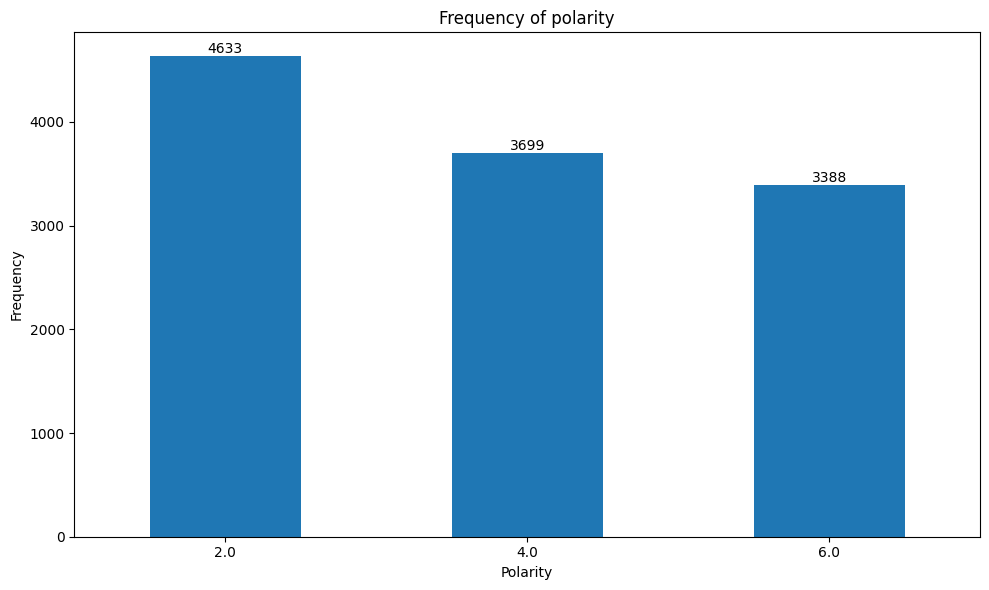

In [ ]:
plt.figure(figsize=(10, 6))
ax = df['polarity'].value_counts().plot(kind='bar')
plt.title('Frequency of polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()

# adding the value of each bar on top of it
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [ ]:
# Add a new column for word count
df['mention_word_count'] = df['mention'].apply(lambda x: len(x.split()))

# View frequency distribution
print(df['mention_word_count'].value_counts().sort_index())

mention_word_count
1     8705
2     2242
3      317
4      175
5       94
6       70
7       34
8       25
9        8
10       9
11      12
12       6
13       5
14       2
15       3
16       4
17       2
18       1
20       1
23       2
25       1
30       1
31       1
Name: count, dtype: int64


In [ ]:
# Filter and display rows where mention has more than 1 word
df[df['mention_word_count'] == 12].head()

,mention,polarity,from,to,sentence,id,mention_word_count
793,"most Americans, including wealthy ones, are not affected now by estate taxes",4.0,34,110,"Mrs. Clinton is also correct that most Americans, including wealthy ones, are not affected now by estate taxes.",allsides_1908_776_49_Hillary Clinton_0_12,12
2574,former Trump campaign manager Paul Manfort and his close associate Rick Gates,2.0,44,121,"A headline on FoxNews.com from Monday, when former Trump campaign manager Paul Manfort and his close associate Rick Gates were asked to turn themselves in to the FBI, read “Mueller facing new Republican pressure to resign in Russia probe.”",allsides_374_150_24_former Trump campaign manager Paul Manfort and his close associate Rick Gates_44_121,12
6266,"Dr. Douglas Steinbrech, dubbed the “go-to surgeon for men” by Forbes magazine",6.0,0,77,"Dr. Douglas Steinbrech, dubbed the “go-to surgeon for men” by Forbes magazine, said he now sees more than 10 times as many male patients as he did just four years ago, and men now outnumber female patients 4 to 1.","polusa_v1_3981903_-1_81_Dr. Douglas Steinbrech, dubbed the “go-to surgeon for men” by Forbes magazine_0_78",12
8391,"Thomas Guenole, a political scientist and left-wing activist participating in the protests",4.0,102,192,"French Protesters Continue Clashes As They Call For Better Economic Conditions Rachel Martin talks to Thomas Guenole, a political scientist and left-wing activist participating in the protests.","polusa_v1_52997877_-1_3_Thomas Guenole, a political scientist and left-wing activist participating in the protests_104_194",12
8622,"Trump pardons ex-media mogul Conrad Black, who wrote flattering biography of Trump",2.0,0,82,"Trump pardons ex-media mogul Conrad Black, who wrote flattering biography of Trump\nThe convicted fraudster is the author of ""Donald J. Trump: A President Like No Other,"" which came out last year.","polusa_v1_55243398_-1_2_former media mogul Conrad Black, who served time in prison for fraud and wrote a flattering biography of Trump_0_85",12


# Modeling

## Partition

In [ ]:
names = ["sentence", "mention"]
X_train, X_test, y_train, y_test = train_test_split(df[names], df["polarity"], test_size=0.2)

In [ ]:
def combine_inputs(df_subset):
    return [f"{row['sentence']} </s> {row['mention']}" for _, row in df_subset.iterrows()]

train_sep = combine_inputs(X_train)
test_sep= combine_inputs(X_test)

label_map = {2: 0, 4: 1, 6: 2}

y_train = y_train.map(label_map).astype(int).tolist()
y_test = y_test.map(label_map).astype(int).tolist()

In [ ]:
test_rw_x = test_rw[names]
test_rw_y = test_rw["polarity"]

test_rw_x = combine_inputs(test_rw_x)
test_rw_y = test_rw_y.map(label_map).astype(int).tolist()

## Dataset Class

In [ ]:
# Dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = tokenizer(
            list(texts),
            padding=True,
            truncation=True,
            return_tensors='pt'
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': int(self.labels[idx])
            }

# Model

In [ ]:
class bertGRUModel(nn.Module):
    def __init__(self, bert_model_name, gru_hidden_size=256, num_layers=2, num_classes=3, dropout_rate=0.1):
        super(bertGRUModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gru = nn.GRU(self.bert.config.hidden_size, gru_hidden_size, num_layers,
                          batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_outputs.last_hidden_state
        gru_output, hidden = self.gru(last_hidden_state)
        forward_hidden = hidden[-2, :, :]
        backward_hidden = hidden[-1, :, :]
        pooled_output = self.dropout(torch.cat((forward_hidden, backward_hidden), dim=1))
        logits = self.fc(pooled_output)
        return logits

class RobertaGRUModel(nn.Module):
    def __init__(self, roberta_model_name, gru_hidden_size=256, num_layers=2, num_classes=3, dropout_rate=0.1):
        super(RobertaGRUModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.gru = nn.GRU(self.roberta.config.hidden_size, gru_hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = roberta_outputs.last_hidden_state
        gru_output, hidden = self.gru(last_hidden_state)
        forward_hidden = hidden[-2, :, :]
        backward_hidden = hidden[-1, :, :]
        pooled_output = self.dropout(gru_output[:, -1, :])
        logits = self.fc(pooled_output)
        return logits

### Bert-GRU

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TextClassificationDataset(train_sep, y_train, tokenizer)
test_dataset = TextClassificationDataset(test_sep, y_test, tokenizer)
test_rw_dataset = TextClassificationDataset(test_rw_x, test_rw_y, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# grid for training
parameters = {
    "learning_rate": [1e-5],
    "batch_size": [16,32],
    "num_layers": [2,3]
}

In [ ]:
# keep track of accuracy and parameters
best_f1 = 0
accuracy = 0
best_parameters = None
criterion = nn.CrossEntropyLoss()


# iterate over combination of hyperparameters
for parameters in ParameterGrid(parameters):

    print(f"Evaluating parameters: {parameters}") # print parameters being used
    torch.cuda.empty_cache()

    # Step 1: model settings
    model = bertGRUModel(bert_model_name='bert-base-uncased', num_layers=parameters["num_layers"],num_classes=3)
    model.cuda()

    optimizer = torch.optim.AdamW(model.parameters(), lr=parameters["learning_rate"])

    # Step 2: load training and testing data in data set class
    train_loader = DataLoader(train_dataset, batch_size=parameters["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=parameters["batch_size"], shuffle=False)

    # Step 3: learning rate scheduler
    train_steps = len(train_loader)  # based on batch size
    scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=train_steps
    )

    # Step 4: training
    model.train()
    for batch in train_loader:
          # inputs
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          optimizer.zero_grad()

          # foward pass
          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          loss = criterion(outputs, labels)

          # backward pass
          loss.backward()

          # optimization
          optimizer.step()
          scheduler.step()  # update learning rate

    # Step 5: evaluation
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for batch in test_loader:
            # inputs
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['labels'].cuda()

            # foward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)

            # predictions
            preds = torch.argmax(logits, axis=1)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # compute f1
    f1 = f1_score(test_labels, test_preds, average='macro')

    # track the best model from f1
    if f1 > best_f1:
      best_f1 = f1
      accuracy = accuracy_score(test_labels, test_preds)
      best_parameters = parameters
      torch.save(model.state_dict(), 'bert_best_model.pt')  # save the best model

# print best training scores
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Best Parameters: {best_parameters}")

Evaluating parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'num_layers': 2}


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Evaluating parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'num_layers': 3}
Evaluating parameters: {'batch_size': 32, 'learning_rate': 1e-05, 'num_layers': 2}
Evaluating parameters: {'batch_size': 32, 'learning_rate': 1e-05, 'num_layers': 3}
Best F1 Score: 0.7712
Accuracy: 0.7803
Best Parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'num_layers': 3}


In [ ]:
# check performance

model = bertGRUModel(bert_model_name='bert-base-uncased', num_layers = 3, num_classes=3)
model.load_state_dict(torch.load('bert_best_model.pt'))
model.to(device)
model.eval()
test_rw_loader = DataLoader(test_rw_dataset, batch_size=16, shuffle=False)

test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_rw_loader:
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Evaluate
f1 = f1_score(test_labels, test_preds, average='macro')
acc = accuracy_score(test_labels, test_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.7723
Test F1 Score: 0.7619


### RobertaGRU

In [ ]:
# grid for training
parameters = {
    "learning_rate": [1e-5],
    "batch_size": [16,32],
    "num_layers": [2,3]
}

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataset = TextClassificationDataset(train_sep, y_train, tokenizer)
test_dataset = TextClassificationDataset(test_sep, y_test, tokenizer)
test_rw_dataset = TextClassificationDataset(test_rw_x, test_rw_y, tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# keep track of accuracy and parameters
best_f1 = 0
accuracy = 0
best_parameters = None
criterion = nn.CrossEntropyLoss()


# iterate over combination of hyperparameters
for parameters in ParameterGrid(parameters):

    print(f"Evaluating parameters: {parameters}") # print parameters being used
    torch.cuda.empty_cache()

    # Step 1: model settings
    model = RobertaGRUModel(roberta_model_name='roberta-base', num_layers=parameters["num_layers"],num_classes=3)
    model.cuda()

    optimizer = torch.optim.AdamW(model.parameters(), lr=parameters["learning_rate"])

    # Step 2: load training and testing data in data set class
    train_loader = DataLoader(train_dataset, batch_size=parameters["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=parameters["batch_size"], shuffle=False)

    # Step 3: learning rate scheduler
    train_steps = len(train_loader)  # based on batch size
    scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=train_steps
    )

    # Step 4: training
    model.train()
    for batch in train_loader:
          # inputs
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          optimizer.zero_grad()

          # foward pass
          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          loss = criterion(outputs, labels)

          # backward pass
          loss.backward()

          # optimization
          optimizer.step()
          scheduler.step()  # update learning rate

    # Step 5: evaluation
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for batch in test_loader:
            # inputs
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['labels'].cuda()

            # foward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)

            # predictions
            preds = torch.argmax(logits, axis=1)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # compute f1
    f1 = f1_score(test_labels, test_preds, average='macro')

    # track the best model from f1
    if f1 > best_f1:
      best_f1 = f1
      accuracy = accuracy_score(test_labels, test_preds)
      best_parameters = parameters
      torch.save(model.state_dict(), 'robertaGRU_best_model.pt')  # save the best model

# print best training scores
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Best Parameters: {best_parameters}")

Evaluating parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'num_layers': 2}


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'num_layers': 3}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating parameters: {'batch_size': 32, 'learning_rate': 1e-05, 'num_layers': 2}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating parameters: {'batch_size': 32, 'learning_rate': 1e-05, 'num_layers': 3}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best F1 Score: 0.8108
Accuracy: 0.8183
Best Parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'num_layers': 3}


In [ ]:
# check performance

model = RobertaGRUModel(roberta_model_name='roberta-base', num_layers = 3, num_classes=3)
model.load_state_dict(torch.load('robertaGRU_best_model.pt'))
model.to(device)
model.eval()
test_rw_loader = DataLoader(test_rw_dataset, batch_size=16, shuffle=False)

test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_rw_loader:
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cuda()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # predictions
        preds = torch.argmax(logits, axis=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Evaluate
f1 = f1_score(test_labels, test_preds, average='macro')
acc = accuracy_score(test_labels, test_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 0.8416
Test F1 Score: 0.8307


### Roberta

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataset = TextClassificationDataset(train_sep, y_train, tokenizer)
test_dataset = TextClassificationDataset(test_sep, y_test, tokenizer)
test_rw_dataset = TextClassificationDataset(test_rw_x, test_rw_y, tokenizer)

In [ ]:
# grid for training
parameters = {
    "learning_rate": [1e-5],
    "batch_size": [16,32]
}

In [ ]:
# keep track of accuracy and parameters
best_f1 = 0
accuracy = 0
best_parameters = None
criterion = nn.CrossEntropyLoss()


# iterate over combination of hyperparameters
for parameters in ParameterGrid(parameters):

    print(f"Evaluating parameters: {parameters}") # print parameters being used
    torch.cuda.empty_cache()

    # Step 1: model settings
    model =  RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=parameters["learning_rate"])

    # Step 2: load training and testing data in data set class
    train_loader = DataLoader(train_dataset, batch_size=parameters["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=parameters["batch_size"], shuffle=False)

    # Step 3: learning rate scheduler
    train_steps = len(train_loader)  # based on batch size
    scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=train_steps
    )

    # Step 4: training
    model.train()
    for batch in train_loader:
          # inputs
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          optimizer.zero_grad()

          # foward pass
          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

          # backward pass
          loss.backward()

          # optimization
          optimizer.step()
          scheduler.step()  # update learning rate

    # Step 5: evaluation
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for batch in test_loader:
            # inputs
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['labels'].cuda()

            # foward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            preds = torch.argmax(outputs.logits, dim=1)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # compute f1
    f1 = f1_score(test_labels, test_preds, average='macro')

    # track the best model from f1
    if f1 > best_f1:
      best_f1 = f1
      accuracy = accuracy_score(test_labels, test_preds)
      best_parameters = parameters
      torch.save(model.state_dict(), 'roberta_best_model.pt')  # save the best model

# print best training scores
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Best Parameters: {best_parameters}")

Evaluating parameters: {'batch_size': 16, 'learning_rate': 1e-05}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating parameters: {'batch_size': 32, 'learning_rate': 1e-05}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best F1 Score: 0.7737
Accuracy: 0.7863
Best Parameters: {'batch_size': 16, 'learning_rate': 1e-05}


In [ ]:
# check performance

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model.load_state_dict(torch.load('roberta_best_model.pt'))
model.to(device)
model.eval()
test_rw_loader = DataLoader(test_rw_dataset, batch_size=16, shuffle=False)

test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_rw_loader:
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Evaluate
f1 = f1_score(test_labels, test_preds, average='macro')
acc = accuracy_score(test_labels, test_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 0.7996
Test F1 Score: 0.7883
